<h1 style="text-align: center;">CNN Segmentation - Neural Network</h1>
<h3 style="text-align: center;">Carlos Moreno</h3>

In [1]:
import os
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt


Run device

In [2]:
if torch.cuda.is_available(): 
    dev = "cuda" 
else: 
    dev = "cpu" 
dev = "cuda"
device = torch.device("cuda")
print(torch.cuda.get_device_name())

NVIDIA GeForce RTX 4070 SUPER


->Load Dataset

In [3]:
class MainDataset(Dataset):
    def __init__(self, filepath):
        self.x, self.y = torch.load(filepath) #Upload ·· x - Number, y - Labels
        self.x = self.x / 255. #Normalizamos
        self.y = F.one_hot(self.y, num_classes=10).to(float) # Enconder para clasificación por vectores
    def __len__(self):  
        return self.x.shape[0]
    def __getitem__(self, ix): 
        x = self.x[ix].unsqueeze(0) 
        y = self.y[ix]
        return x, y

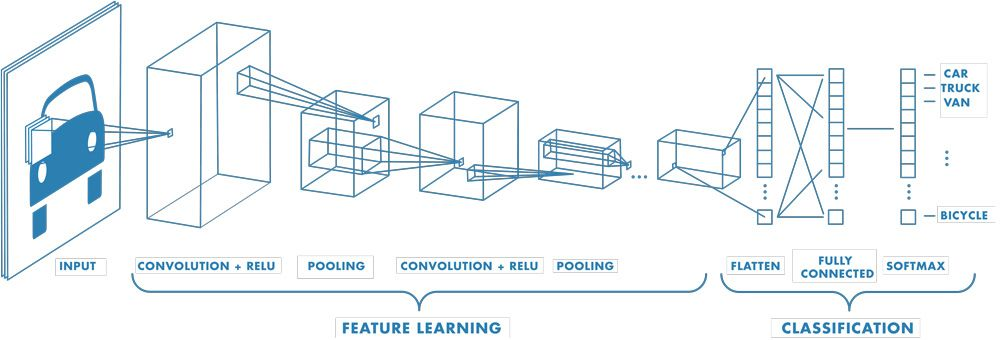

In [4]:
class ConvNeuralNet(nn.Module):
    def __init__(self, num_classes = 10):    
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 7 * 7, num_classes)
        self.R = nn.ReLU()
    def forward(self,x):
        x = self.R(self.conv1(x))
        x = self.pool(x)
        x = self.R(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x

Clase Dataset (Inicializa los datos y los reordena)

In [5]:
train_ds = MainDataset('..\\Database\\MNIST\\processed\\training.pt')
test_ds = MainDataset('..\\Database\\MNIST\\processed\\test.pt')

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True) # se divide el dataset en batch de a 5
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True) # se divide el dataset en batch de a 5

C:\Users\Eoweo\AppData\Local\Temp\ipykernel_23748\1286090659.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.x, self.y = torch.load(filepath) #Upload ·· x - Number,

In [6]:
def CheckAccuracy(loader, model, name, device = dev):
    num_corrects = 0
    num_samples = 0
    model.eval()
    x_fail = []
    y_fail = []
    yhat_fail = []
    with torch.no_grad():
        for x, y in loader:
            # send the data to the device
            x = x.to(device)
            y = y.to(device)
    
            # prepare the data for the model
            #x = x.reshape(-1, 784)
    
            # forward
            y_hat = model(x)
    
            # calculations for accuracy
            _, predictions = torch.max(y_hat, dim=1)
            labels = torch.argmax(y, dim=1)

            num_corrects += (predictions == labels).sum().item()
            
            
            incorrect_indices = (predictions != labels).nonzero(as_tuple=True)[0]
            
            if incorrect_indices.numel() > 0: 
                x_fail.extend(x[incorrect_indices]) 
                y_fail.extend(y[incorrect_indices]) 
                yhat_fail.extend(y_hat[incorrect_indices]) 
            
            num_samples += y.size(0)

    Accuracy = num_corrects/num_samples*100
    print(f"Accuracy of {name} = {Accuracy:.2f}; Received {num_corrects}/{num_samples}")
    model.train()
    return Accuracy, x_fail, y_fail, yhat_fail

## Optimización

In [7]:
def train_model(dl, f, n_epochs=20, device = dev):
    # Optimization
    opt = Adam(f.parameters(), lr=3e-4) # karpathy's constant
    L = nn.CrossEntropyLoss()
	
    # Train model
    losses = []
    epochs = []
    accuracy = []
    for epoch in range(n_epochs):
        N = len(dl)
            
        for i, (x, y) in enumerate(dl):
            x, y = x.to(device), y.to(device)
            opt.zero_grad() 
            loss_value = L(f(x), y) 
            loss_value.backward() 
            opt.step() 
            # Store training data
            epochs.append(epoch+i/N)
            losses.append(loss_value.item())
            
        print(f"Epoch {epoch + 1} is done; loss = { sum (losses[epoch*i: (epoch + 1)*i]) / 12000 }")
        accuracy.append(CheckAccuracy(train_dl, f, "Train Data", device=dev)[0])
        
    return np.array(epochs), np.array(losses), accuracy

In [8]:
class Report:
    def __init__(self, epoch, loss, Accuracy, type = "Training", n_epochs=20):
        self.epoch = epoch
        self.loss = loss
        self.type = type
        self.n_epochs = n_epochs
        self.Accuracy = Accuracy
        self.epoch_data_avgd = self.epoch.reshape(self.n_epochs,-1).mean(axis=1)
        self.loss_data_avgd = self.loss.reshape(self.n_epochs,-1).mean(axis=1)
    
    def plot_training(self):
        plt.figure(figsize=(5,4))
        plt.plot(self.epoch_data_avgd, self.loss_data_avgd, 'o--', label='Loss', color="Cyan")
        plt.xlabel('Epoch Number')
        plt.ylabel('Cross Entropy')
        plt.title(f'Cross Entropy (avgd per epoch) - {self.type}')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

    def plot_accuracy(self):
        plt.figure(figsize=(5, 4))
        plt.plot([i for i in range(1, self.n_epochs + 1)], self.Accuracy, 'd--', label='Accuracy', color='orange')
        plt.xlabel('Epoch Number')
        plt.ylabel('Accuracy (%)')
        plt.ylim(min(self.Accuracy)*0.9, 100)
        plt.xlim(0, self.n_epochs)
        plt.title(f'Accuracy Over Epochs - {self.type}')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [9]:
f = ConvNeuralNet()
f.to(device)

ConvNeuralNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=784, out_features=10, bias=True)
  (R): ReLU()
)

In [10]:
n_epochs = 20
epoch_data, loss_data, Accurasy_data = train_model(train_dl, f, n_epochs, device= "cuda")

Epoch 1 is done; loss = 0.0379212304857346
Accuracy of Train Data = 94.43; Received 56658/60000
Epoch 2 is done; loss = 0.01136614079980346
Accuracy of Train Data = 96.63; Received 57980/60000
Epoch 3 is done; loss = 0.00774855116288117
Accuracy of Train Data = 97.57; Received 58543/60000
Epoch 4 is done; loss = 0.0060590511802984404
Accuracy of Train Data = 98.09; Received 58854/60000
Epoch 5 is done; loss = 0.005150707482355755
Accuracy of Train Data = 98.29; Received 58976/60000
Epoch 6 is done; loss = 0.004487149083367255
Accuracy of Train Data = 98.51; Received 59105/60000
Epoch 7 is done; loss = 0.004051139553671407
Accuracy of Train Data = 98.41; Received 59045/60000
Epoch 8 is done; loss = 0.0037774709693697136
Accuracy of Train Data = 98.64; Received 59185/60000
Epoch 9 is done; loss = 0.00345970981598741
Accuracy of Train Data = 98.78; Received 59265/60000
Epoch 10 is done; loss = 0.0032533664530547787
Accuracy of Train Data = 98.85; Received 59308/60000
Epoch 11 is done; los

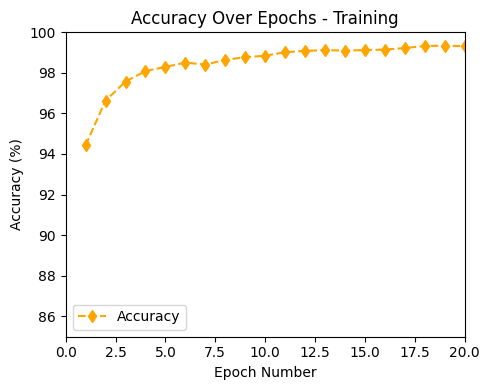

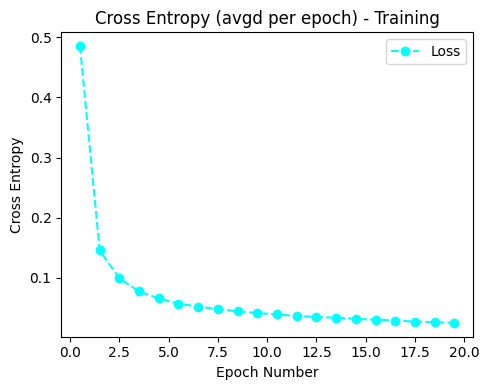

(None, None)

In [11]:
Analisis = Report(epoch_data, loss_data, Accurasy_data,  n_epochs =20)
Analisis.plot_accuracy(), Analisis.plot_training()

In [12]:
acurracy, x_fail, y_fail, yhat_fail = CheckAccuracy(test_dl, f, "Test Data")

Accuracy of Test Data = 98.77; Received 9877/10000


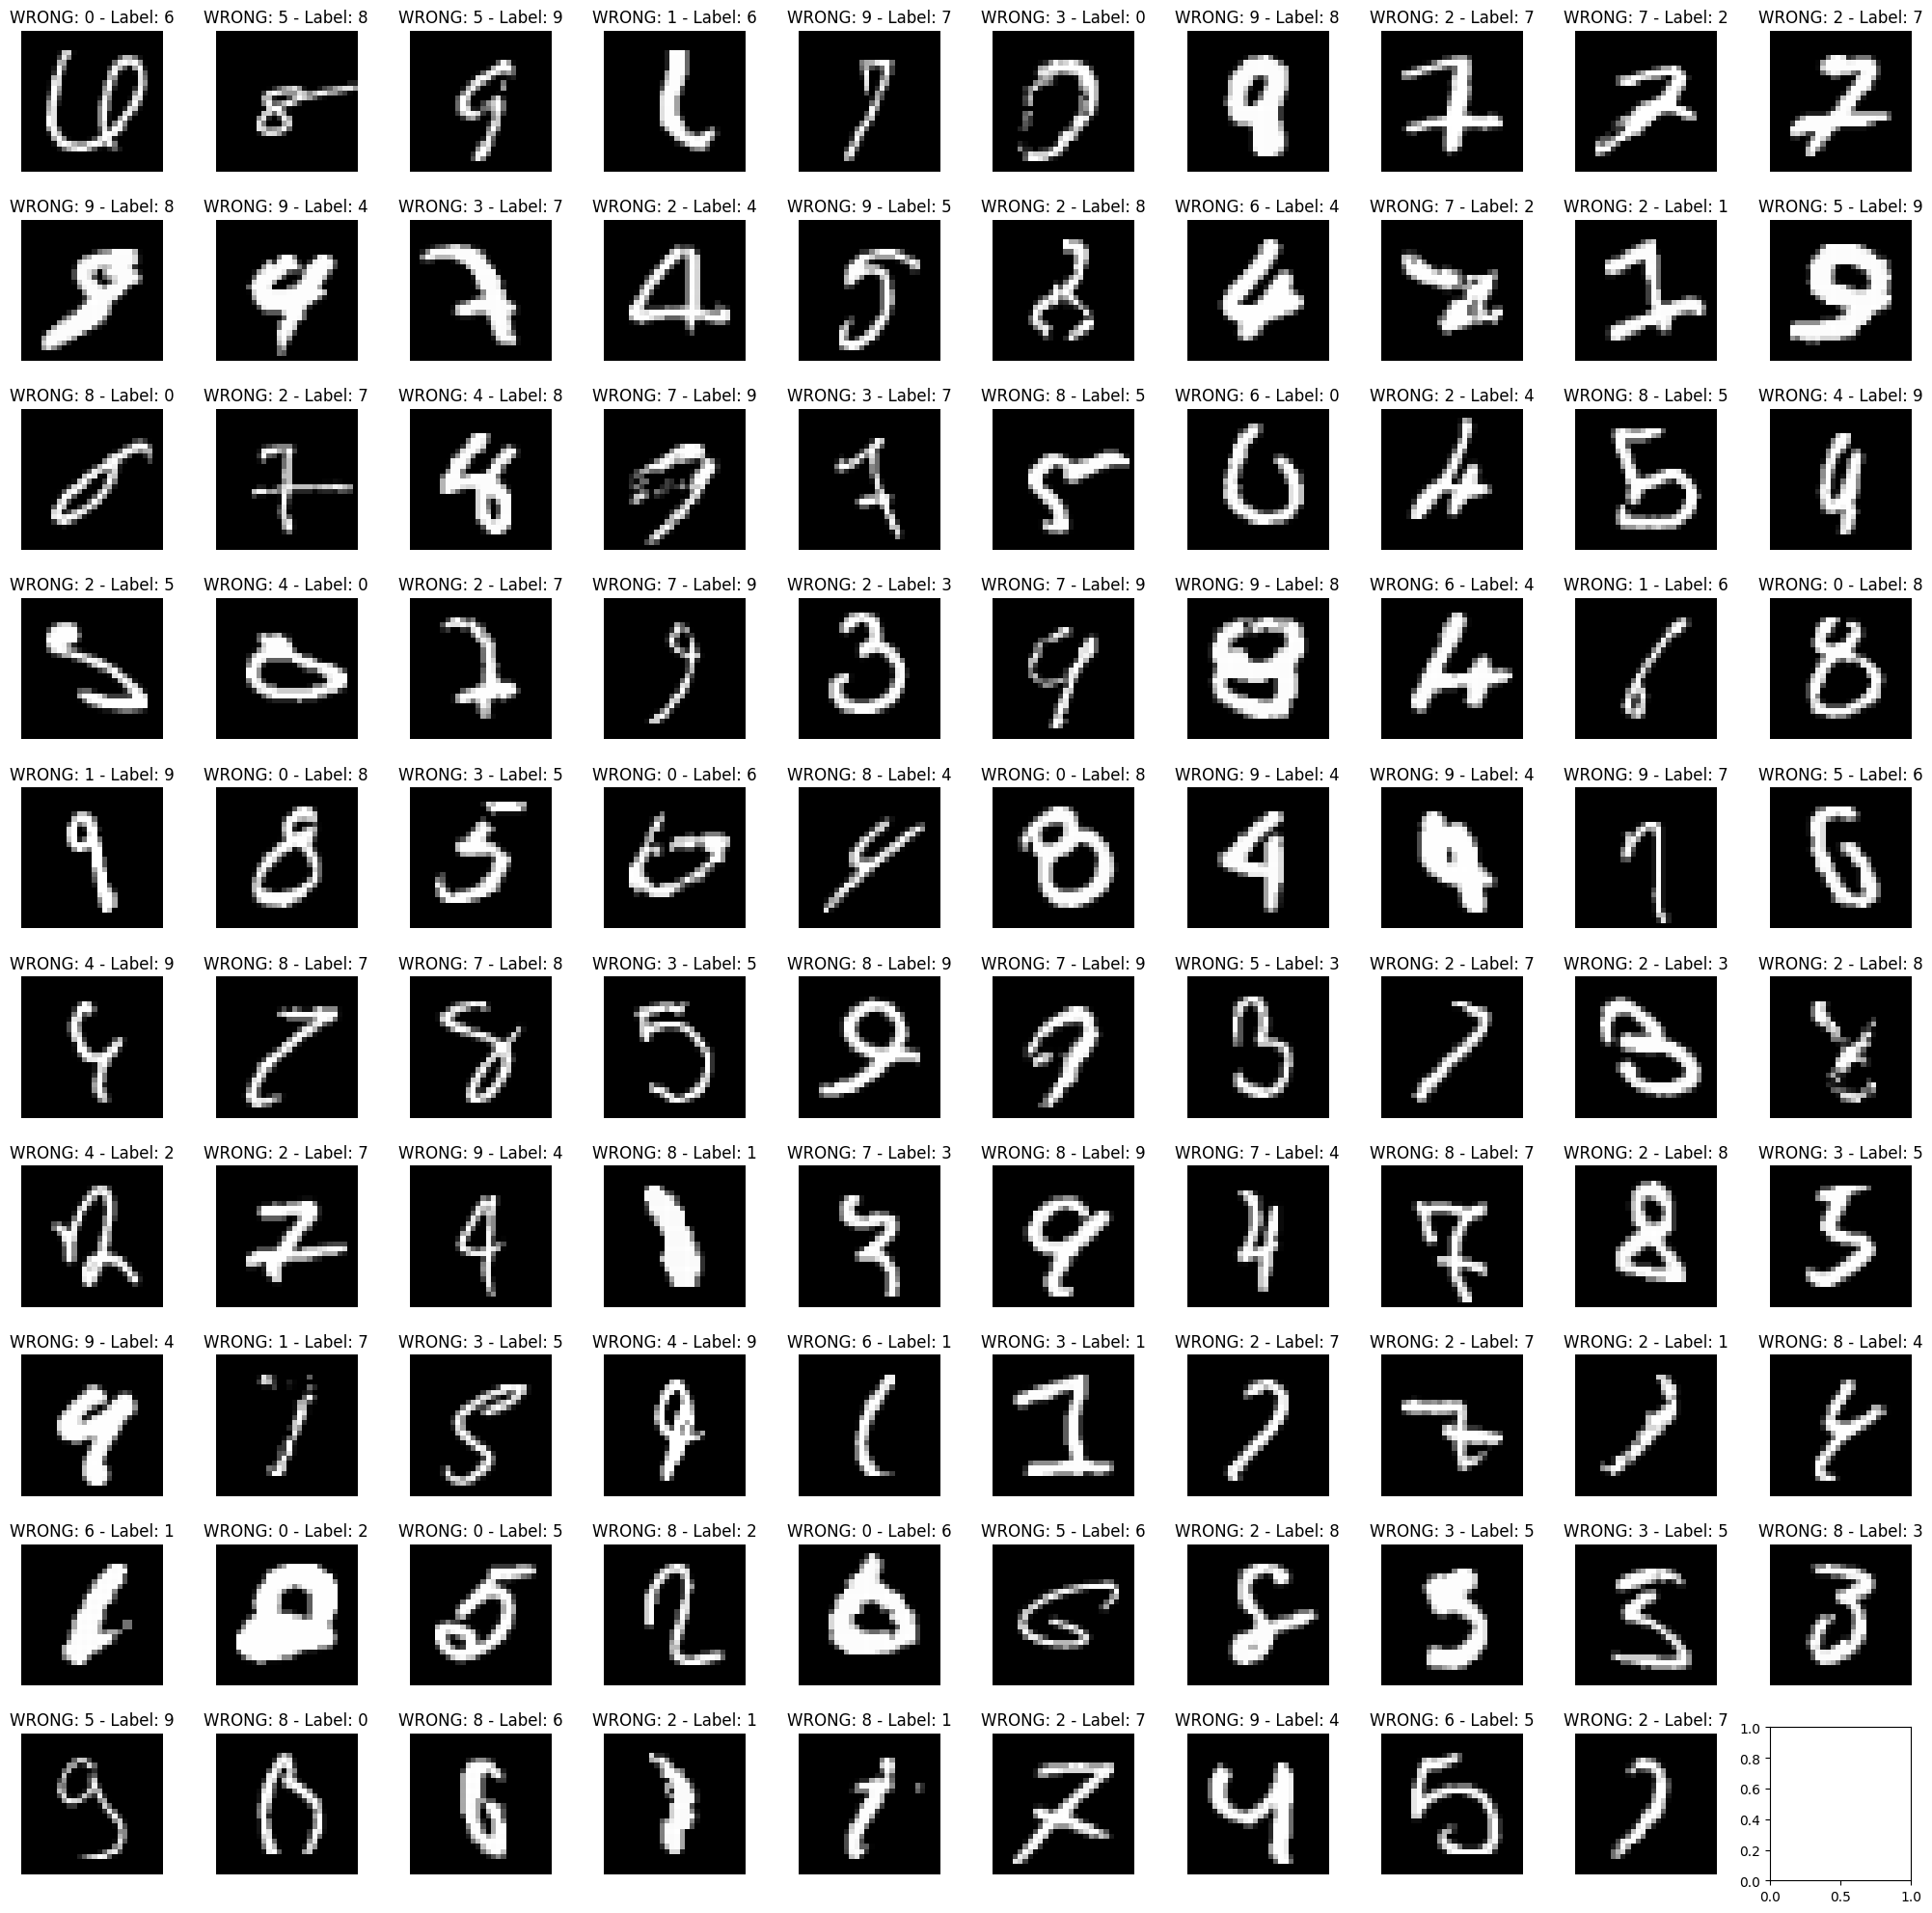

In [13]:

fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i in range(1, 100):
    plt.subplot(10, 10, i)
    
    # Move the tensor to CPU and convert it to NumPy for visualization
    img = x_fail[i].cpu().numpy().reshape(28, 28)
    predicted_label = np.argmax(yhat_fail[i].cpu().numpy())
    true_label = np.argmax(y_fail[i].cpu().numpy())
    
    plt.imshow(img, cmap="gray")
    plt.title(f"WRONG: {predicted_label} - Label: {true_label}")
    plt.axis("off")
    
fig.tight_layout()
plt.show()